In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import stats
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def get_summary(dat):

    dtypes_dict = dat.dtypes.apply(lambda x: x.name).to_dict()

    numeric = [x for x in dtypes_dict.keys() if dtypes_dict[x] == 'float64' or dtypes_dict[x] == 'int64']
    chars = [x for x in dtypes_dict.keys() if dtypes_dict[x] == 'object']

    type_numeric = ['numeric'] * len(numeric)
    type_chars = ['char'] * len(chars)

    numeric_counts = dat.loc[:, numeric].count().to_dict()
    numeric_populated = list(numeric_counts.values())
    numeric_pct = [str((round(x / len(dat), 2)) * 100) + '%' for x in numeric_populated]
    numeric_zero = [sum(dat.loc[:, x] == 0) for x in numeric]

    numeric_s = pd.DataFrame(list(zip(numeric, numeric_populated, numeric_pct, numeric_zero)),
                             columns=['Name', 'Non_NA_Values', 'Pct_Non_NA', 'Num_Zeros'])

    numeric_cols_df = pd.concat([numeric_s,
                                 dat.describe().transpose().reset_index().drop(['count', 'index'], axis=1)],
                                axis=1)

    char_counts = dat.loc[:, chars].count().to_dict()
    char_populated = list(char_counts.values())
    char_pct = [str((round(x / len(dat), 3)) * 100) + '%' for x in char_populated]
    char_zero = [sum(dat.loc[:, x] == 0) for x in chars]

    chars_unique = [len(dat.loc[:, x].unique()) for x in chars]
    chars_val_max = [dat.loc[:, x].value_counts().idxmax() for x in chars]

    chars_df = pd.DataFrame(
        list(zip(chars, char_populated, char_pct, char_zero, chars_unique, chars_val_max)),
        columns=['Name', 'Non_NA_Values', 'Pct_Non_NA', 'Num_Zeros', 'Unique', 'Most_Common'])

    which = input('Would you like a table of numeric or char columns? (N/C)')
    if which == 'N':
        return numeric_cols_df
    elif which == 'C':
        return chars_df

In [3]:
dat = pd.read_excel('../data/card transactions.xlsx')

In [4]:
dat

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96748,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0
96749,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0
96750,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0
96751,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0


In [5]:
get_summary(dat)

Would you like a table of numeric or char columns? (N/C)N


,Name,Non_NA_Values,Pct_Non_NA,Num_Zeros,mean,std,min,25%,50%,75%,max
0,Recnum,96753,100.0%,0,4.837700e+04,27930.329635,1.000000e+00,2.418900e+04,4.837700e+04,7.256500e+04,9.675300e+04
1,Cardnum,96753,100.0%,0,5.142202e+09,55670.837531,5.142110e+09,5.142152e+09,5.142196e+09,5.142246e+09,5.142847e+09
2,Merch zip,92097,95.0%,0,4.470660e+04,28369.537945,1.000000e+00,2.085500e+04,3.811800e+04,6.310300e+04,9.999900e+04
3,Amount,96753,100.0%,0,4.278857e+02,10006.140302,1.000000e-02,3.348000e+01,1.379800e+02,4.282000e+02,3.102046e+06
4,Fraud,96753,100.0%,95694,1.094540e-02,0.104047,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [6]:
get_summary(dat)

Would you like a table of numeric or char columns? (N/C)C


,Name,Non_NA_Values,Pct_Non_NA,Num_Zeros,Unique,Most_Common
0,Merchnum,93378,96.5%,0,13092,930090121224
1,Merch description,96753,100.0%,0,13126,GSA-FSS-ADV
2,Merch state,95558,98.8%,0,228,TN
3,Transtype,96753,100.0%,0,4,P


### Removing outliers

Single large transaction outlier and keep only P type transactions

In [7]:
dat = dat[(dat['Amount']!=dat['Amount'].max()) & (dat['Transtype']=='P')]

### Filling in missing values 

#### Merchnum

In [8]:
dat['Merchnum'].isna().sum()

3198

In [9]:
fill_merchnum = dat[dat['Merchnum'].isna()]
keep_merchnum = dat[dat['Merchnum'].notna()]

In [10]:
merch_description_modes = dat.loc[:, ['Merch description', 'Merchnum']].groupby(['Merch description'])['Merchnum'].agg(pd.Series.mode)

In [11]:
mdm_dict = merch_description_modes.to_dict()

In [12]:
for idx, row in fill_merchnum.iterrows():
    if pd.isnull(fill_merchnum.loc[idx, 'Merchnum']):
        fill_value = mdm_dict[fill_merchnum.loc[idx, 'Merch description']]
        if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
            continue
        elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
            fill_merchnum.loc[idx, 'Merchnum'] = fill_value.flat[0]
        else:
            fill_merchnum.loc[idx, 'Merchnum'] = fill_value

In [13]:
zip_modes = dat.loc[:, ['Merch zip', 'Merchnum']].groupby(['Merch zip'])['Merchnum'].agg(pd.Series.mode)

In [14]:
zip_dict = zip_modes.to_dict()

In [15]:
for idx, row in fill_merchnum.iterrows():
    if pd.isnull(fill_merchnum.loc[idx, 'Merchnum']):
        if not pd.isnull(fill_merchnum.loc[idx, 'Merch zip']):
            fill_value = zip_dict[fill_merchnum.loc[idx, 'Merch zip']]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchnum.loc[idx, 'Merchnum'] = fill_value.flat[0]
            else:
                fill_merchnum.loc[idx, 'Merchnum'] = fill_value
        else:
            continue

In [16]:
state_modes = dat.loc[:, ['Merch state', 'Merchnum']].groupby(['Merch state'])['Merchnum'].apply(lambda x: x.mode())

In [17]:
state_dict = pd.DataFrame(state_modes).reset_index().drop('level_1', axis=1).set_index('Merch state').to_dict()['Merchnum']

In [18]:
for idx, row in fill_merchnum.iterrows():
    if pd.isnull(fill_merchnum.loc[idx, 'Merchnum']):
        if not pd.isnull(fill_merchnum.loc[idx, 'Merch state']):
            if fill_merchnum.loc[idx, 'Merch state'] in state_dict:
                fill_value = state_dict[fill_merchnum.loc[idx, 'Merch state']]
                if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                    continue
                elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                    fill_merchnum.loc[idx, 'Merchnum'] = fill_value.flat[0]
                else:
                    fill_merchnum.loc[idx, 'Merchnum'] = fill_value
        else:
            continue

In [19]:
fill_merchnum['Merchnum'] = fill_merchnum['Merchnum'].fillna(fill_merchnum['Merchnum'].mode()[0])

In [20]:
dat = pd.concat([fill_merchnum, keep_merchnum], ignore_index=True).sort_values('Recnum')

#### Merch state

In [21]:
dat['Merch state'].isna().sum()

1020

In [22]:
fill_merchstate = dat[dat['Merch state'].isna()]
keep_merchstate = dat[dat['Merch state'].notna()]

In [23]:
merch_zip_modes = dat.loc[:, ['Merch zip', 'Merch state']].groupby(['Merch zip'])['Merch state'].agg(pd.Series.mode)

In [24]:
mzip_dict = merch_zip_modes.to_dict()

In [25]:
for idx, row in fill_merchstate.iterrows():
    if pd.isnull(fill_merchstate.loc[idx, 'Merch state']):
        if not pd.isnull(fill_merchstate.loc[idx, 'Merch zip']):
            fill_value = mzip_dict[fill_merchstate.loc[idx, 'Merch zip']]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value.flat[0]
            else:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value

In [26]:
merchnum_modes = dat.loc[:, ['Merchnum', 'Merch state']].groupby(['Merchnum'])['Merch state'].agg(pd.Series.mode)

In [27]:
merchnum_dict = merchnum_modes.to_dict()

In [28]:
for idx, row in fill_merchstate.iterrows():
    if pd.isnull(fill_merchstate.loc[idx, 'Merch state']):
        if not pd.isnull(fill_merchstate.loc[idx, 'Merchnum']):
            fill_value = merchnum_dict[fill_merchstate.loc[idx, 'Merchnum']]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value.flat[0]
            else:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value

In [29]:
merch_desc_modes = dat.loc[:, ['Merch description', 'Merch state']].groupby(['Merch description'])['Merch state'].agg(pd.Series.mode)

In [30]:
mdesc_dict = merch_desc_modes.to_dict()

In [31]:
for idx, row in fill_merchstate.iterrows():
    if pd.isnull(fill_merchstate.loc[idx, 'Merch state']):
        if not pd.isnull(fill_merchstate.loc[idx, 'Merch description']):
            fill_value = mdesc_dict[fill_merchstate.loc[idx, 'Merch description']]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value.flat[0]
            else:
                fill_merchstate.loc[idx, 'Merch state'] = fill_value

In [32]:
for idx, row in fill_merchstate.iterrows():
    if pd.isnull(fill_merchstate.loc[idx, 'Merch state']):
        fill_merchstate.loc[idx, 'Merch state'] = 'TN'

In [33]:
dat = pd.concat([fill_merchstate, keep_merchstate], ignore_index=True).sort_values('Recnum')

#### Merch zip

In [34]:
dat['Merch zip'].isna().sum()

4300

In [35]:
fill_merchzip = dat[dat['Merch zip'].isna()]
keep_merchzip = dat[dat['Merch zip'].notna()]

In [36]:
merch_statenum_modes = dat.loc[:, ['Merch state', 'Merch description', 'Merch zip']].groupby(['Merch state', 'Merch description'])['Merch zip'].apply(lambda x: x.mode())

In [37]:
msn_dict = merch_statenum_modes.to_dict()

In [38]:
for idx, row in fill_merchzip.iterrows():
    if pd.isnull(fill_merchzip.loc[idx, 'Merch zip']):
        if (fill_merchzip.loc[idx, 'Merch state'], fill_merchzip.loc[idx, 'Merch description'], 0) in msn_dict:
            fill_value = msn_dict[(fill_merchzip.loc[idx, 'Merch state'], fill_merchzip.loc[idx, 'Merch description'], 0)]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchzip.loc[idx, 'Merch zip'] = fill_value.flat[0]
            else:
                fill_merchzip.loc[idx, 'Merch zip'] = fill_value

In [39]:
merch_statenum_modes = dat.loc[:, ['Merch state', 'Merchnum', 'Merch zip']].groupby(['Merch state', 'Merchnum'])['Merch zip'].apply(lambda x: x.mode())

In [40]:
msn_dict = merch_statenum_modes.to_dict()

In [41]:
for idx, row in fill_merchzip.iterrows():
    if pd.isnull(fill_merchzip.loc[idx, 'Merch zip']):
        if (fill_merchzip.loc[idx, 'Merch state'], fill_merchzip.loc[idx, 'Merchnum'], 0) in msn_dict:
            fill_value = msn_dict[(fill_merchzip.loc[idx, 'Merch state'], fill_merchzip.loc[idx, 'Merchnum'], 0)]
            if isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size == 0:
                continue
            elif isinstance(fill_value, (np.ndarray, np.generic)) and fill_value.size > 1:
                fill_merchzip.loc[idx, 'Merch zip'] = fill_value.flat[0]
            else:
                fill_merchzip.loc[idx, 'Merch zip'] = fill_value

In [42]:
for idx, row in fill_merchzip.iterrows():
    if pd.isnull(fill_merchzip.loc[idx, 'Merch zip']):
        fill_merchzip.loc[idx, 'Merch zip'] = '38118.0'

In [43]:
dat = pd.concat([fill_merchzip, keep_merchzip], ignore_index=True).sort_values('Recnum')

In [44]:
dat

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
4300,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
4301,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
4302,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
4303,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4304,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0


In [45]:
get_summary(dat)

Would you like a table of numeric or char columns? (N/C)N


,Name,Non_NA_Values,Pct_Non_NA,Num_Zeros,mean,std,min,25%,50%,75%,max
0,Recnum,96397,100.0%,0,4.836548e+04,27945.003883,1.000000e+00,2.415400e+04,4.836500e+04,7.257800e+04,9.675300e+04
1,Cardnum,96397,100.0%,0,5.142202e+09,55658.254252,5.142110e+09,5.142152e+09,5.142196e+09,5.142245e+09,5.142847e+09
2,Amount,96397,100.0%,0,3.958585e+02,832.330197,1.000000e-02,3.346000e+01,1.379800e+02,4.282500e+02,4.790000e+04
3,Fraud,96397,100.0%,95338,1.098582e-02,0.104236,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [46]:
get_summary(dat)

Would you like a table of numeric or char columns? (N/C)C


,Name,Non_NA_Values,Pct_Non_NA,Num_Zeros,Unique,Most_Common
0,Merchnum,96397,100.0%,0,13090,930090121224
1,Merch description,96397,100.0%,0,12966,GSA-FSS-ADV
2,Merch state,96397,100.0%,0,59,TN
3,Merch zip,96397,100.0%,0,4568,38118
4,Transtype,96397,100.0%,0,1,P


In [165]:
dat.to_csv('../data/card_transactions_nona.csv', index=False)

In [166]:
dat = pd.read_csv('../data/card_transactions_nona.csv')

### Creating features

#### Frequency Variables

In [236]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum', 'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state']:
        for time in [0, 1, 3, 7, 14, 30]:
            split = col.split('_')
            if len(split) == 1:
                split = split[0]
                if time == 1:
                    offset = pd.offsets.Day(time)
                s = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.Timedelta(days=time), periods=time+1))
                filt = list(s.map(lambda x: x.strftime('%Y-%m-%d')))
                keep = dat[(dat['Date'].isin(filt))&(dat[col]==dat.loc[idx, col])]
                dat.loc[idx, 'avg_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].mean(), 5)
                dat.loc[idx, 'max_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].max(), 5)
                dat.loc[idx, 'median_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].median(), 5)
                dat.loc[idx, 'total_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].sum(), 5)

                dat.loc[idx, 'actual_norm_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].mean(), 5)
                dat.loc[idx, 'actual_max_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].max(), 5)
                dat.loc[idx, 'actual_median_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].median(), 5)
                dat.loc[idx, 'actual_total_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].sum(), 5)
                
            else:
                split1, split2 = split
                s = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.offsets.Day(time), periods=time+1))
                filt = list(s.map(lambda x: x.strftime('%Y-%m-%d')))
                keep = dat[(dat['Date'].isin(filt))&(dat[split1]==dat.loc[idx, split1])&(dat[split2]==dat.loc[idx, split2])]
                dat.loc[idx, 'avg_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].mean(), 5)
                dat.loc[idx, 'max_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].max(), 5)
                dat.loc[idx, 'median_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].median(), 5)
                dat.loc[idx, 'total_'+col+'_amount_over_'+str(time)+'days'] = round(keep['Amount'].sum(), 5)

                dat.loc[idx, 'actual_norm_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].mean(), 5)
                dat.loc[idx, 'actual_max_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].max(), 5)
                dat.loc[idx, 'actual_median_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].median(), 5)
                dat.loc[idx, 'actual_total_'+col+'_amount_over_'+str(time)+'days'] = round(dat.loc[idx, 'Amount']/keep['Amount'].sum(), 5)

In [246]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum', 'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state']:
        for time in [0, 1, 3, 7, 14, 30]:
                split = col.split('_')
                if len(split) == 1:
                    split = split[0]
                    s = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.Timedelta(days=time), periods=time+1))
                    filt = list(s.map(lambda x: x.strftime('%Y-%m-%d')))
                    keep = dat[(dat['Date'].isin(filt))&(dat[col]==dat.loc[idx, col])]
                    dat.loc[idx, 'freq_by_'+col+'over_'+str(time)+'_days'] = len(keep)
                else:
                    split1, split2 = split
                    s = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.Timedelta(days=time), periods=time+1))
                    filt = list(s.map(lambda x: x.strftime('%Y-%m-%d')))
                    keep = dat[(dat['Date'].isin(filt))&(dat[split1]==dat.loc[idx, split1])&(dat[split2]==dat.loc[idx, split2])]
                    dat.loc[idx, 'freq_by_'+col+'over_'+str(time)+'_days'] = len(keep)

In [250]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum', 'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state']:
        split = col.split('_')
        if len(split) == 1:
            split = split[0]
            keep = dat[(dat[split]==dat.loc[idx, split])&(dat['Date']<dat.loc[idx, 'Date'])].sort_values('Date', ascending=False)
            if len(keep) == 0:
                dat.loc[idx, 'days_since_last_with_'+col] = 0
            else:
                dat.loc[idx, 'days_since_last_with_'+col] = (pd.Timestamp(dat.loc[idx, 'Date']) - pd.Timestamp(keep.iloc[0]['Date'])).days
        else:
            split1, split2 = split
            keep = dat[(dat[split1]==dat.loc[idx, split1])&(dat[split2]==dat.loc[idx, split2])&(dat['Date']<dat.loc[idx, 'Date'])].sort_values('Date', ascending=False)
            if len(keep) == 0:
                dat.loc[idx, 'days_since_last_with_'+col] = 0
            else:
                dat.loc[idx, 'days_since_last_with_'+col] = (pd.Timestamp(dat.loc[idx, 'Date']) - pd.Timestamp(keep.iloc[0]['Date'])).days

In [263]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum']:
        for time_num in [0, 1]:
            for time_denom in [7, 14, 30]:
                s_num = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.Timedelta(days=time_num), periods=time_num+1))
                filt_num = list(s_num.map(lambda x: x.strftime('%Y-%m-%d')))
                keep_num = dat[(dat['Date'].isin(filt_num))&(dat[col]==dat.loc[idx, col])]
                
                s_denom = pd.Series(pd.date_range(pd.Timestamp(dat.loc[idx, 'Date'])-pd.Timedelta(days=time_denom), periods=time_denom+1))
                filt_denom = list(s_denom.map(lambda x: x.strftime('%Y-%m-%d')))
                keep_denom = dat[(dat['Date'].isin(filt_denom))&(dat[col]==dat.loc[idx, col])]
                
                dat.loc[idx, 'trans_amount_with_'+col+'_over_'+str(time_num)+'_norm_by_'+str(time_denom)] = round(len(keep_num)/keep_denom.groupby('Date').count()['Recnum'].mean(), 5)
                dat.loc[idx, 'avg_trans_amount_with_'+col+'_over_'+str(time_num)+'_norm_by_'+str(time_denom)] = round(keep_num['Amount'].sum()/keep_denom.groupby('Date').mean()['Amount'][0], 5)

In [147]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum', 'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state']:
        for time in [0, 1, 3, 7, 14, 30]:
            dat.loc[idx, 'trans_amount_minus_avg_'+col+str(time)] = round(dat.loc[idx, 'Amount']-dat.loc[idx, 'avg_'+col+'_amount_over_'+str(time)+'days'], 5)
            dat.loc[idx, 'trans_amount_minus_max_'+col+str(time)] = round(dat.loc[idx, 'Amount']-dat.loc[idx, 'max_'+col+'_amount_over_'+str(time)+'days'], 5)
            dat.loc[idx, 'trans_amount_minus_median_'+col+str(time)] = round(dat.loc[idx, 'Amount']-dat.loc[idx, 'median_'+col+'_amount_over_'+str(time)+'days'], 5)

In [154]:
for idx, row in dat.iterrows():
    for col in ['Cardnum', 'Merchnum', 'Cardnum_Merchnum', 'Cardnum_Merch zip', 'Cardnum_Merch state']:
        split = col.split('_')
        if len(split)==1:
            split = split[0]
            keep = dat[(dat[split]==dat.loc[idx, split])&(dat['Date']<dat.loc[idx, 'Date'])].sort_values('Date', ascending=False)
            if len(keep)==0:
                dat.loc[idx, 'trans_amount_minus_last_with_'+col] = round(dat.loc[idx, 'Amount'], 5)
            else:
                dat.loc[idx, 'trans_amount_minus_last_with_'+col] = round(dat.loc[idx, 'Amount'] - keep.iloc[0]['Amount'], 5)
        else:
            split1, split2 = split
            keep = dat[(dat[split1]==dat.loc[idx, split1])&(dat[split2]==dat.loc[idx, split2])&(dat['Date']<dat.loc[idx, 'Date'])].sort_values('Date', ascending=False)
            if len(keep) == 0:
                dat.loc[idx, 'trans_amount_minus_last_with_'+col] = round(dat.loc[idx, 'Amount'], 5)
            else:
                dat.loc[idx, 'trans_amount_minus_last_with_'+col] = round(dat.loc[idx, 'Amount'] - keep.iloc[0]['Amount'], 5)

In [159]:
dat.to_csv('../data/card_transactions_features.csv', index=False)

# Variable Creation Above

######################################################################################

In [2]:
dat = pd.read_csv('../data/card_transactions_features.csv')

In [149]:
dat

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,trans_amount_minus_median_Cardnum_Merch state3,trans_amount_minus_avg_Cardnum_Merch state7,trans_amount_minus_max_Cardnum_Merch state7,trans_amount_minus_median_Cardnum_Merch state7,trans_amount_minus_avg_Cardnum_Merch state14,trans_amount_minus_max_Cardnum_Merch state14,trans_amount_minus_median_Cardnum_Merch state14,trans_amount_minus_avg_Cardnum_Merch state30,trans_amount_minus_max_Cardnum_Merch state30,trans_amount_minus_median_Cardnum_Merch state30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.000,-0.00455,-0.05,0.000,-0.00455,-0.05,0.000,-0.00455,-0.05,0.000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,-0.120,-0.11143,-0.18,-0.120,-0.11143,-0.18,-0.120,-0.11143,-0.18,-0.120
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.000,-0.00455,-0.05,0.000,-0.00455,-0.05,0.000,-0.00455,-0.05,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,...,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,...,-324.375,-324.37500,-648.75,-324.375,-599.02500,-1266.25,-564.925,-599.02500,-1266.25,-564.925
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,...,145.855,145.85500,0.00,145.855,145.85500,0.00,145.855,145.85500,0.00,145.855
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,...,0.000,0.00000,0.00,0.000,0.00000,0.00,0.000,1286.82000,0.00,1718.780


In [112]:
dat['Date'] = pd.to_datetime(dat['Date'])
dat['DOW'] = pd.to_datetime(dat['Date']).dt.day_name()
dat['OOT'] = np.where((dat['Date'].dt.month==11) | (dat['Date'].dt.month==12), 1, 0)

In [114]:
not_oot = dat[dat['OOT']!=1]

c=4; nmid=20
num_instances_catvar = not_oot.groupby('DOW').size()
y_avg = not_oot['Fraud'].mean()
y_catvar = not_oot.groupby('DOW')['Fraud'].mean()
y_catvar_smooth = y_avg + (y_catvar - y_avg) / (1 + np.exp(-(num_instances_catvar - nmid) / c))
dat['DOW_risk'] = dat['DOW'].map(y_catvar_smooth)

plt_dow = dat.set_index('DOW')
DOW_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt_dow = plt_dow.loc[DOW_order].reset_index()

In [118]:
c=4; nmid=20
num_instances_catvar = not_oot.groupby('Merch state').size()
y_catvar = not_oot.groupby('Merch state')['Fraud'].mean()
y_catvar_smooth = y_avg + (y_catvar - y_avg) / (1 + np.exp(-(num_instances_catvar - nmid) / c))
dat['state_risk'] = dat['Merch state'].map(y_catvar_smooth)

plt_state = dat.sort_values('state_risk', ascending=False)

DOW
Friday       0.025994
Monday       0.008711
Saturday     0.010095
Sunday       0.009630
Thursday     0.018626
Tuesday      0.007127
Wednesday    0.009788
Name: DOW_risk, dtype: float64


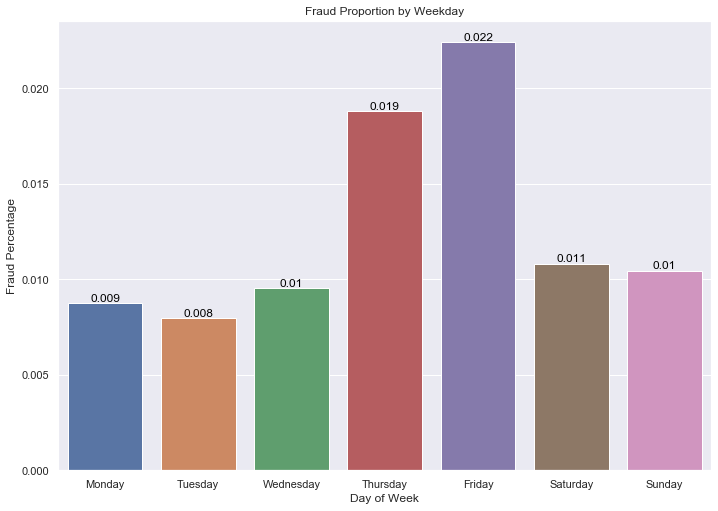

In [120]:
print(dat.groupby('DOW')['DOW_risk'].mean())

ax = sns.barplot(x='DOW', y='Fraud', data=plt_dow, ci=None)

for p in ax.patches:
    ax.text(p.get_x()+.4, p.get_height()+.0001, str(round(p.get_height(),3)), color='black', ha='center')
    
plt.xlabel('Day of Week')
plt.ylabel('Fraud Percentage')
plt.title('Fraud Proportion by Weekday')
plt.show()

Merch state
AB    1.029144e-02
AK    3.608225e-16
AL    6.872852e-03
AR    3.911833e-04
AZ    3.184713e-03
BC    4.588361e-03
CA    1.490538e-02
CO    1.139601e-03
CT    3.550296e-03
DC    1.763224e-02
DE    6.108886e-07
FL    2.142475e-03
GA    1.148369e-03
HI    9.480677e-03
IA    7.632783e-16
ID    5.204170e-18
IL    6.167401e-03
IN    8.438819e-02
KS    2.835539e-03
KY    2.347418e-03
LA    9.801188e-16
MA    3.303965e-03
MB    1.036479e-02
MD    1.509223e-02
ME    6.188718e-12
MI    6.764374e-03
MN    2.457002e-03
MO    9.583134e-04
MS    0.000000e+00
MT    4.819778e-12
NC    2.419634e-03
ND    7.014063e-05
NE    0.000000e+00
NH    6.257822e-03
NJ    2.345353e-03
NM    1.851852e-02
NS    1.033255e-02
NV    3.200000e-03
NY    2.393747e-02
OH    2.457185e-02
OK    2.832861e-03
ON    6.522873e-13
OR    2.463433e-02
PA    1.811765e-02
PQ    8.928409e-03
QC    1.033255e-02
RI    0.000000e+00
SC    7.874016e-03
SD    1.449275e-02
TN    7.910697e-03
TX    1.268882e-02
US    1.039004e-02


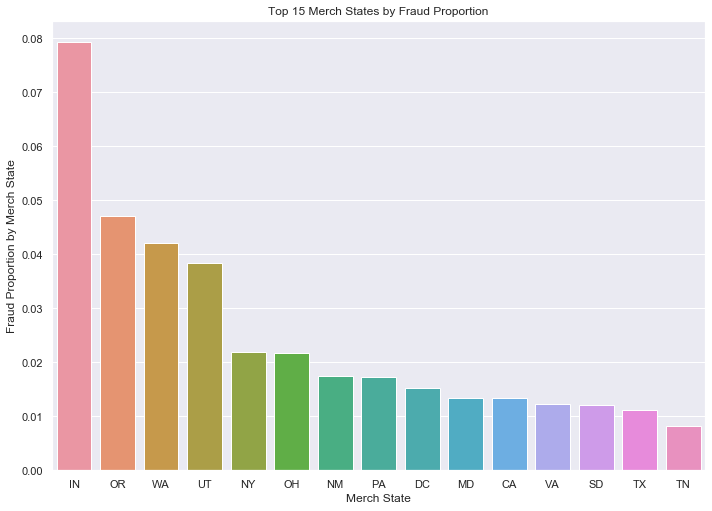

In [121]:
print(dat.groupby('Merch state')['state_risk'].mean())

sns.barplot(x='Merch state', y='Fraud', data=risk2.iloc[:15,])
plt.xlabel('Merch State')
plt.ylabel('Fraud Proportion by Merch State')
plt.title('Top 15 Merch States by Fraud Proportion')
plt.show()

In [8]:
404-10

394

In [3]:
pd.set_option('display.max_rows', 500)
dat.iloc[:, 10:].describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
avg_Cardnum_amount_over_0days,3.958585e+02,703.748276,0.14000,28392.84000
max_Cardnum_amount_over_0days,5.867924e+02,1195.495754,0.14000,47900.00000
median_Cardnum_amount_over_0days,3.707746e+02,688.369746,0.14000,28392.84000
total_Cardnum_amount_over_0days,1.090261e+03,5487.338798,0.14000,218301.83000
actual_norm_Cardnum_amount_over_0days,1.000000e+00,0.603753,0.00004,31.79739
actual_max_Cardnum_amount_over_0days,7.872885e-01,0.347369,0.00001,1.00000
actual_median_Cardnum_amount_over_0days,1.643675e+00,11.609910,0.00009,805.84474
actual_total_Cardnum_amount_over_0days,6.421880e-01,0.392928,0.00001,1.00000
avg_Cardnum_amount_over_1days,3.967789e+02,667.952147,0.14000,28392.84000
max_Cardnum_amount_over_1days,6.836955e+02,1321.230238,0.14000,47900.00000
